# Instituto Tecnológico de Costa Rica

## Programa de Ciencia de los Datos

Curso: Machine Learning


### Proyecto Final

#### Objetivo:  PREDICCION DEL PRECIO DE UN DIAMANTE.

Estudiantes:

> Claudia Alcazar Urena

> Natalia Rojas Canales

Profesor:

> Dr. Felipe Meza

Lunes 09 de Setiembre de 2019

<div>
    <div class="col-sm-12"><p class="h2">Descripcion de los Datos</p> 
    </div>
</div>


Información tomada del sitio: https://www.kaggle.com/shivam2503/diamonds/downloads/diamonds.zip/1


> * **carat**: Peso en quilates del diamante.
> * **cut**: Describa la calidad de corte del diamante. Calidad en orden creciente: Fair, Good, Very Good, Premium, Ideal.
> * **color**: Color del diamante, con D siendo el mejor y J el peor.
> * **clarity**: Que tan visibles son las inclusiones dentro del diamante: (en orden de mejor a peor, FL = impecable, I3 = inclusiones de nivel 3) FL, IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3
> * **depth**: La altura de un diamante, medida desde el culet hasta la mesa, dividida por su diámetro medio
> * **table**: El ancho de la mesa del diamante expresado como un porcentaje de su diámetro promedio.
> * **price**: precio en dólares.
> * **DIMENSIONES**:
           - x: largo en milimetros  
           - y: Ancho en milimetros
           - z: profundidad en milimetros


Debe tener instalado en el ambiente de trabajo Pandas, Keras etc.
**IMPORTANTE**
Para algunos reportes mostrados aquí, si lo ejecuta en colab no serán mostrados, en caso de Jupyter, debe ejecutar la siguiente instalación:

                       pip install jupyter_contrib_nbextensions

                       jupyter contrib nbextension install --user
                       
                       jupyter nbextension enable python-markdown/main


<div>
    <div class="col-sm-12"><p class="h2">Importar Librerias</p> 
    </div>
</div>

In [1]:
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import pytz

from tabulate import tabulate
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import KFold

Using TensorFlow backend.


<div>
    <div class="col-sm-12"><p class="h2">Cargar Conjunto de Datos de Diamantes</p> 
    </div>
</div>

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/NataliaGRC/DataScience/master/diamonds.csv')


<div>
    <div class="col-sm-12"><p class="h2">Análisis Exploratorio (EDA)</p> 
    </div>
</div>

In [0]:
#Métodos Auxiliares 
#Necesarios para la creación de la visualización de las variables

def porcentaje(observations, count):
    return ((observations/count)*100).round(2)

def conteo_tipo_dato():
    
    numerico = 0
    categorico = 0
    na = 0

    for data_type in df.dtypes:      
        
        if (data_type == "int64" or data_type == "float64"):
            numerico = numerico + 1
        elif (data_type == "object"):
            categorico = categorico + 1
        else:
            na = na + 1
    
    return {
         'numerico': numerico,
         'categorico': categorico,
         'bool': 0,
         'na': na,
    }
    
def traer_tipo_dato(column):
    
    data_type = column.dtype
    
    if (data_type == "int64"):
        return "Númerico" 
    elif (data_type == "object"):
        return "Categorico" 
    elif (data_type == "float64"):
        return "Flotante" 
    else:
        return "No Soportado"
    
        
def traer_infomacion_general():
    
        return {
        'columns': len(df.columns),
        'rows': len(df.index),
        'zeros': (df == 0).astype(int).sum(axis=1).sum(),
        'ptc_zeros':  porcentaje((df == 0).astype(int).sum(axis=1).sum(), len(df.index)),
        'duplicates':  df.duplicated().astype(int).sum(),
        'ptc_duplicates':  porcentaje(df.duplicated().astype(int).sum(), len(df.index)),
        'memory':  df.memory_usage().sum()
    }
    
    
def traer_informacion_general_por_columna(df, column_name, column):
    
    count = column.count()
    return {
        
        'count':  count,
        'unique': df.nunique(axis=0)[column_name],
        'ptc_unique': porcentaje(df.nunique(axis=0)[column_name], count),
        'missing':((column == 0) | (column == None)).astype(int).sum(),
        'ptc_missing':porcentaje(((column == 0) | (column == None)).astype(int).sum(), count),
        'null':((column == 0) | (column == None)).astype(int).sum(),
        'ptc_null':porcentaje(((column == 0) | (column == None)).astype(int).sum(), count)
    }


def traer_estadisticas_cuantiles_por_columna(column):
    
    return {
        'min':  column.min().round(2),
        'max':  column.max().round(2),
        'mean':  column.mean(),
        'quantile1':  column.quantile(q=0.25).round(2),
        'quantile2':  column.quantile(q=0.50).round(2),
        'quantile3':  column.quantile(q=0.75).round(2),
        'median':  column.median().round(2)
    }

def traer_estadisticas_descriptivos_por_columna(column):
    
    return {
        'std':  column.std(),
        'kurtosis':  column.kurt(),
        'mad':  column.mad(),
        'skewness':  column.skew(),
        'variance':  column.var(),
        'memory_size':  column.memory_usage()
    }

def traer_estadisticas_categoricas_por_columna(column):
    
    return {
        'min':  column.str.len().min(),
        'max':  column.str.len().max(),
        'mean':  column.str.len().mean()
    }

def graficar_distribucion(column, column_name):
    
    counts = column.value_counts(sort=True, ascending=False)
    
    ax = counts.head(10).plot(kind='bar',figsize=(14,8))
    ax.set_xlabel(column_name.upper())
    ax.set_ylabel("FRECUENCIA")


def graficar_frecuencia(column, column_name):
   
    ax = column.plot(kind='hist',bins=10,rwidth=0.5, figsize=(14,8))
    ax.set_xlabel(column_name.upper())
    ax.set_ylabel("FRECUENCIA")

def graficar_outliers():
    
    columns = []
    for column_name in df.columns: 
        if df[column_name].dtype == "int64" or df[column_name].dtype == "float":
            columns.append(column_name) 
    
    df.boxplot(column =columns, grid = True, figsize=(25,8))        
    
#Estandarizar el encabezado 

df.columns = map(str.upper, df.columns)

#Estandarizar las Variables Categoricas

df['CUT'] = df['CUT'].str.upper()
df['COLOR'] = df['COLOR'].str.upper()
df['CLARITY'] = df['CLARITY'].str.upper()

{{info_general = traer_infomacion_general()}}
{{conteo_general = conteo_tipo_dato()}}

<div>
    <div class="col-sm-5"><p class="h2">Información General</p>
    <table>
        <tbody>
            <tr>
                <th>Total de Columnas</th>
                <td>{{ info_general['columns'] }}</td>
            </tr>
            <tr>
                <th>Total de Registros</th>
                <td>{{ info_general['rows'] }} </td>
            </tr>
            <tr>
                <th>Total de Zeros</th>
                <td>{{ info_general['zeros'] }} ({{ info_general['ptc_zeros'] }}%)</td>
            </tr>
            <tr>
                <th>Total de Duplicados</th>
                <td>{{ info_general['duplicates'] }} ({{ info_general['ptc_duplicates'] }} %) </td>
            </tr>
            <tr>
                <th>Memoria</th>
                <td> {{ info_general['memory'] }} MiB </td>
            </tr>
        </tbody>
    </table>
</div>
<div class="col-sm-6 col-sm-offset-1">
    <p class="h2">Tipos de Variables</p>
    <table> <tbody>
        <tr>
            <th>Númerico</th>
            <td>{{ conteo_general['numerico'] }}</td>
        </tr>
        <tr>
            <th>Categorico</th>
            <td>{{ conteo_general['categorico'] }}</td>
        </tr>
        <tr>
            <th>Booleano</th>
            <td>{{ conteo_general['bool'] }}</td>
        </tr>
        <tr>
            <th>No Soportado</th>
            <td>{{ conteo_general['na'] }}</td>
        </tr>
        </tbody>  
    </table>
</div>
<div class="col-sm-5"><p class="h2"><br>Muestra de Datos<br></p></div>
<div class="col-sm-12">
<p class="h3"><br><br>Primeros 5 Registros<br><br></p>
{{ print(tabulate(df.head(5), tablefmt="pipe", headers="keys", showindex=False) ) }}
</div>
<div class="col-sm-12">
<p class="h3"><br><br>Últimos 5 Registros<br><br></p>
{{ print(tabulate(df.tail(5), tablefmt="pipe", headers="keys", showindex=False) ) }}
</div>

<div>
    <div class="col-sm-12"><p class="h2">Variables</p> 
    </div>
</div>

{{ column_name = "UNNAMED" }}
{{ column = df[column_name] }}
{{ tipo_dato = traer_tipo_dato(column) }}
{{ datos_generales = traer_informacion_general_por_columna(df, column_name, column) }}
{{ datos_cuantitativos = traer_estadisticas_cuantiles_por_columna(column) }}
{{ datos_descriptivos = traer_estadisticas_descriptivos_por_columna(column) }}
      
<div class="row variable">
    <div class="col-sm-2">
        <p class="h4" title={{column_name}}>{{ column_name }}<br><small>{{ tipo_dato }}</small></p>
    </div>
    <div class="col-sm-8">
        <div class="row">
            <div class="col-sm-4">
                <p class="h4" title="General">General<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Total</th>
                            <td>{{  datos_generales["count"] }}</td>
                        </tr>
                        <tr>
                            <th>Únicos (%)</th>
                            <td>{{ datos_generales["ptc_unique"] }} %</td>
                        </tr>
                        <tr>
                            <th>Únicos (n)</th>
                            <td>{{ datos_generales["unique"] }}</td>
                        </tr>
                        <tr>
                            <th>Zeros (%)</th>
                            <td>{{ datos_generales["ptc_missing"] }} %</td>
                        </tr>
                        <tr>
                            <th>Zeros (n)</th>
                            <td>{{ datos_generales["missing"] }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Cuantiles">Estadísticas Cuantiles<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Mínimo</th>
                            <td>{{ datos_cuantitativos["min"] }}</td>
                        </tr>
                        <tr>
                            <th>Promedio</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["mean"]) }}</td>
                        </tr>
                        <tr>
                            <th>Máximo</th>
                            <td>{{ datos_cuantitativos["max"] }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (25)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile1"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (50)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile2"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (75)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile3"]) }}</td>
                        </tr>
                        <tr>
                            <th>Mediana</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["median"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Descriptivas">Estadísticas Descriptivas<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Desviación Estandar</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["std"]) }}</td>
                        </tr>
                        <tr>
                            <th>Kurtosis</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["kurtosis"]) }}</td>
                        </tr>
                        <tr>
                            <th>MAD</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["mad"]) }}</td>
                        </tr>
                        <tr>
                            <th>Skewness</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["skewness"]) }}</td>
                        </tr>
                        <tr>
                            <th>Varianza</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["variance"]) }}</td>
                        </tr>
                        <tr>
                            <th>Memoria</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["memory_size"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
        </div>
    </div>
    <div class="col-sm-12">
        <br>
        <br>
        <br>
    </div>
    <div class="col-sm-12">        
         <p class="h4" title="Histograma"><center>Histograma<br></center></p>
    </div>
    <div class="col-sm-12">
        <center>
        {{ graficar_frecuencia(column, column_name)}}
        </center>
    </div>
        

{{ column_name = "CARAT" }}
{{ column = df[column_name] }}
{{ tipo_dato = traer_tipo_dato(column) }}
{{ datos_generales = traer_informacion_general_por_columna(df, column_name, column) }}
{{ datos_cuantitativos = traer_estadisticas_cuantiles_por_columna(column) }}
{{ datos_descriptivos = traer_estadisticas_descriptivos_por_columna(column) }}
      
<div class="row variable">
    <div class="col-sm-2">
        <p class="h4" title={{column_name}}>{{ column_name }}<br><small>{{ tipo_dato }}</small></p>
    </div>
    <div class="col-sm-8">
        <div class="row">
            <div class="col-sm-4">
                <p class="h4" title="General">General<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Total</th>
                            <td>{{  datos_generales["count"] }}</td>
                        </tr>
                        <tr>
                            <th>Únicos (%)</th>
                            <td>{{ datos_generales["ptc_unique"] }} %</td>
                        </tr>
                        <tr>
                            <th>Únicos (n)</th>
                            <td>{{ datos_generales["unique"] }}</td>
                        </tr>
                        <tr>
                            <th>Zeros (%)</th>
                            <td>{{ datos_generales["ptc_missing"] }} %</td>
                        </tr>
                        <tr>
                            <th>Zeros (n)</th>
                            <td>{{ datos_generales["missing"] }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Cuantiles">Estadísticas Cuantiles<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Mínimo</th>
                            <td>{{ datos_cuantitativos["min"] }}</td>
                        </tr>
                        <tr>
                            <th>Promedio</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["mean"]) }}</td>
                        </tr>
                        <tr>
                            <th>Máximo</th>
                            <td>{{ datos_cuantitativos["max"] }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (25)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile1"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (50)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile2"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (75)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile3"]) }}</td>
                        </tr>
                        <tr>
                            <th>Mediana</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["median"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Descriptivas">Estadísticas Descriptivas<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Desviación Estandar</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["std"]) }}</td>
                        </tr>
                        <tr>
                            <th>Kurtosis</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["kurtosis"]) }}</td>
                        </tr>
                        <tr>
                            <th>MAD</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["mad"]) }}</td>
                        </tr>
                        <tr>
                            <th>Skewness</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["skewness"]) }}</td>
                        </tr>
                        <tr>
                            <th>Varianza</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["variance"]) }}</td>
                        </tr>
                        <tr>
                            <th>Memoria</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["memory_size"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
        </div>
    </div>
    <div class="col-sm-12">
        <br>
        <br>
        <br>
    </div>
    <div class="col-sm-12">        
         <p class="h4" title="Histograma"><center>Histograma<br></center></p>
    </div>
    <div class="col-sm-12">
        <center>
        {{ graficar_frecuencia(column, column_name)}}
        </center>
    </div>
        

{{ column_name = "CUT" }}
{{ column = df[column_name] }}
{{ tipo_dato = traer_tipo_dato(column) }}
{{ datos_generales = traer_informacion_general_por_columna(df, column_name, column) }}
{{ datos_categoricos = traer_estadisticas_categoricas_por_columna(column) }}
      
<div class="row variable">
    <div class="col-sm-2">
        <p class="h4" title={{column_name}}>{{ column_name }}<br><small>{{ tipo_dato }}</small></p>
    </div>
    <div class="col-sm-8">
        <div class="row">
            <div class="col-sm-4">
                <p class="h4" title="General">General<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Total</th>
                            <td>{{  datos_generales["count"] }}</td>
                        </tr>
                        <tr>
                            <th>Únicos (%)</th>
                            <td>{{ datos_generales["ptc_unique"] }} %</td>
                        </tr>
                        <tr>
                            <th>Únicos (n)</th>
                            <td>{{ datos_generales["unique"] }}</td>
                        </tr>
                        <tr>
                            <th>Valores Faltantes (%)</th>
                            <td>{{ datos_generales["ptc_null"] }} %</td>
                        </tr>
                        <tr>
                            <th>Valores Faltantes (n)</th>
                            <td>{{ datos_generales["null"] }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Composición ">Composición<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Longitud Mínima</th>
                            <td>{{ datos_categoricos["min"] }}</td>
                        </tr>
                        <tr>
                            <th>Longitud Promedio</th>
                            <td>{{ "{:.2f}".format(datos_categoricos["mean"]) }}</td>
                        </tr>
                        <tr>
                            <th>Longitud Máxima</th>
                            <td>{{ datos_categoricos["max"] }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
        </div>
    </div>
    <div class="col-sm-12">
        <br>
        <br>
        <br>
    </div>
    <div class="col-sm-12">        
         <p class="h4" title="Histograma"><center>Histograma<br></center></p>
    </div>
    <div class="col-sm-12">
        <center>
        {{ graficar_distribucion(column, column_name)}}
        </center>
    </div>
        

{{ column_name = "COLOR" }}
{{ column = df[column_name] }}
{{ tipo_dato = traer_tipo_dato(column) }}
{{ datos_generales = traer_informacion_general_por_columna(df, column_name, column) }}
{{ datos_categoricos = traer_estadisticas_categoricas_por_columna(column) }}
      
<div class="row variable">
    <div class="col-sm-2">
        <p class="h4" title={{column_name}}>{{ column_name }}<br><small>{{ tipo_dato }}</small></p>
    </div>
    <div class="col-sm-8">
        <div class="row">
            <div class="col-sm-4">
                <p class="h4" title="General">General<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Total</th>
                            <td>{{  datos_generales["count"] }}</td>
                        </tr>
                        <tr>
                            <th>Únicos (%)</th>
                            <td>{{ datos_generales["ptc_unique"] }} %</td>
                        </tr>
                        <tr>
                            <th>Únicos (n)</th>
                            <td>{{ datos_generales["unique"] }}</td>
                        </tr>
                        <tr>
                            <th>Valores Faltantes (%)</th>
                            <td>{{ datos_generales["ptc_null"] }} %</td>
                        </tr>
                        <tr>
                            <th>Valores Faltantes (n)</th>
                            <td>{{ datos_generales["null"] }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Composición ">Composición<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Longitud Mínima</th>
                            <td>{{ datos_categoricos["min"] }}</td>
                        </tr>
                        <tr>
                            <th>Longitud Promedio</th>
                            <td>{{ "{:.2f}".format(datos_categoricos["mean"]) }}</td>
                        </tr>
                        <tr>
                            <th>Longitud Máxima</th>
                            <td>{{ datos_categoricos["max"] }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
        </div>
    </div>
    <div class="col-sm-12">
        <br>
        <br>
        <br>
    </div>
    <div class="col-sm-12">        
         <p class="h4" title="Histograma"><center>Histograma<br></center></p>
    </div>
    <div class="col-sm-12">
        <center>
        {{ graficar_distribucion(column, column_name)}}
        </center>
    </div>
        

{{ column_name = "CLARITY" }}
{{ column = df[column_name] }}
{{ tipo_dato = traer_tipo_dato(column) }}
{{ datos_generales = traer_informacion_general_por_columna(df, column_name, column) }}
{{ datos_categoricos = traer_estadisticas_categoricas_por_columna(column) }}
      
<div class="row variable">
    <div class="col-sm-2">
        <p class="h4" title={{column_name}}>{{ column_name }}<br><small>{{ tipo_dato }}</small></p>
    </div>
    <div class="col-sm-8">
        <div class="row">
            <div class="col-sm-4">
                <p class="h4" title="General">General<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Total</th>
                            <td>{{  datos_generales["count"] }}</td>
                        </tr>
                        <tr>
                            <th>Únicos (%)</th>
                            <td>{{ datos_generales["ptc_unique"] }} %</td>
                        </tr>
                        <tr>
                            <th>Únicos (n)</th>
                            <td>{{ datos_generales["unique"] }}</td>
                        </tr>
                        <tr>
                            <th>Valores Faltantes (%)</th>
                            <td>{{ datos_generales["ptc_null"] }} %</td>
                        </tr>
                        <tr>
                            <th>Valores Faltantes (n)</th>
                            <td>{{ datos_generales["null"] }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Composición ">Composición<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Longitud Mínima</th>
                            <td>{{ datos_categoricos["min"] }}</td>
                        </tr>
                        <tr>
                            <th>Longitud Promedio</th>
                            <td>{{ "{:.2f}".format(datos_categoricos["mean"]) }}</td>
                        </tr>
                        <tr>
                            <th>Longitud Máxima</th>
                            <td>{{ datos_categoricos["max"] }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
        </div>
    </div>
    <div class="col-sm-12">
        <br>
        <br>
        <br>
    </div>
    <div class="col-sm-12">        
         <p class="h4" title="Histograma"><center>Histograma<br></center></p>
    </div>
    <div class="col-sm-12">
        <center>
        {{ graficar_distribucion(column, column_name)}}
        </center>
    </div>
        

{{ column_name = "DEPTH" }}
{{ column = df[column_name] }}
{{ tipo_dato = traer_tipo_dato(column) }}
{{ datos_generales = traer_informacion_general_por_columna(df, column_name, column) }}
{{ datos_cuantitativos = traer_estadisticas_cuantiles_por_columna(column) }}
{{ datos_descriptivos = traer_estadisticas_descriptivos_por_columna(column) }}
      
<div class="row variable">
    <div class="col-sm-2">
        <p class="h4" title={{column_name}}>{{ column_name }}<br><small>{{ tipo_dato }}</small></p>
    </div>
    <div class="col-sm-8">
        <div class="row">
            <div class="col-sm-4">
                <p class="h4" title="General">General<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Total</th>
                            <td>{{  datos_generales["count"] }}</td>
                        </tr>
                        <tr>
                            <th>Únicos (%)</th>
                            <td>{{ datos_generales["ptc_unique"] }} %</td>
                        </tr>
                        <tr>
                            <th>Únicos (n)</th>
                            <td>{{ datos_generales["unique"] }}</td>
                        </tr>
                        <tr>
                            <th>Zeros (%)</th>
                            <td>{{ datos_generales["ptc_missing"] }} %</td>
                        </tr>
                        <tr>
                            <th>Zeros (n)</th>
                            <td>{{ datos_generales["missing"] }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Cuantiles">Estadísticas Cuantiles<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Mínimo</th>
                            <td>{{ datos_cuantitativos["min"] }}</td>
                        </tr>
                        <tr>
                            <th>Promedio</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["mean"]) }}</td>
                        </tr>
                        <tr>
                            <th>Máximo</th>
                            <td>{{ datos_cuantitativos["max"] }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (25)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile1"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (50)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile2"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (75)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile3"]) }}</td>
                        </tr>
                        <tr>
                            <th>Mediana</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["median"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Descriptivas">Estadísticas Descriptivas<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Desviación Estandar</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["std"]) }}</td>
                        </tr>
                        <tr>
                            <th>Kurtosis</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["kurtosis"]) }}</td>
                        </tr>
                        <tr>
                            <th>MAD</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["mad"]) }}</td>
                        </tr>
                        <tr>
                            <th>Skewness</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["skewness"]) }}</td>
                        </tr>
                        <tr>
                            <th>Varianza</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["variance"]) }}</td>
                        </tr>
                        <tr>
                            <th>Memoria</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["memory_size"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
        </div>
    </div>
    <div class="col-sm-12">
        <br>
        <br>
        <br>
    </div>
    <div class="col-sm-12">        
         <p class="h4" title="Histograma"><center>Histograma<br></center></p>
    </div>
    <div class="col-sm-12">
        <center>
        {{ graficar_frecuencia(column, column_name)}}
        </center>
    </div>
        

{{ column_name = "TABLE" }}
{{ column = df[column_name] }}
{{ tipo_dato = traer_tipo_dato(column) }}
{{ datos_generales = traer_informacion_general_por_columna(df, column_name, column) }}
{{ datos_cuantitativos = traer_estadisticas_cuantiles_por_columna(column) }}
{{ datos_descriptivos = traer_estadisticas_descriptivos_por_columna(column) }}
      
<div class="row variable">
    <div class="col-sm-2">
        <p class="h4" title={{column_name}}>{{ column_name }}<br><small>{{ tipo_dato }}</small></p>
    </div>
    <div class="col-sm-8">
        <div class="row">
            <div class="col-sm-4">
                <p class="h4" title="General">General<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Total</th>
                            <td>{{  datos_generales["count"] }}</td>
                        </tr>
                        <tr>
                            <th>Únicos (%)</th>
                            <td>{{ datos_generales["ptc_unique"] }} %</td>
                        </tr>
                        <tr>
                            <th>Únicos (n)</th>
                            <td>{{ datos_generales["unique"] }}</td>
                        </tr>
                        <tr>
                            <th>Zeros (%)</th>
                            <td>{{ datos_generales["ptc_missing"] }} %</td>
                        </tr>
                        <tr>
                            <th>Zeros (n)</th>
                            <td>{{ datos_generales["missing"] }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Cuantiles">Estadísticas Cuantiles<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Mínimo</th>
                            <td>{{ datos_cuantitativos["min"] }}</td>
                        </tr>
                        <tr>
                            <th>Promedio</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["mean"]) }}</td>
                        </tr>
                        <tr>
                            <th>Máximo</th>
                            <td>{{ datos_cuantitativos["max"] }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (25)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile1"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (50)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile2"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (75)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile3"]) }}</td>
                        </tr>
                        <tr>
                            <th>Mediana</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["median"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Descriptivas">Estadísticas Descriptivas<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Desviación Estandar</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["std"]) }}</td>
                        </tr>
                        <tr>
                            <th>Kurtosis</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["kurtosis"]) }}</td>
                        </tr>
                        <tr>
                            <th>MAD</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["mad"]) }}</td>
                        </tr>
                        <tr>
                            <th>Skewness</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["skewness"]) }}</td>
                        </tr>
                        <tr>
                            <th>Varianza</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["variance"]) }}</td>
                        </tr>
                        <tr>
                            <th>Memoria</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["memory_size"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
        </div>
    </div>
    <div class="col-sm-12">
        <br>
        <br>
        <br>
    </div>
    <div class="col-sm-12">        
         <p class="h4" title="Histograma"><center>Histograma<br></center></p>
    </div>
    <div class="col-sm-12">
        <center>
        {{ graficar_frecuencia(column, column_name)}}
        </center>
    </div>
        

{{ column_name = "PRICE" }}
{{ column = df[column_name] }}
{{ tipo_dato = traer_tipo_dato(column) }}
{{ datos_generales = traer_informacion_general_por_columna(df, column_name, column) }}
{{ datos_cuantitativos = traer_estadisticas_cuantiles_por_columna(column) }}
{{ datos_descriptivos = traer_estadisticas_descriptivos_por_columna(column) }}
      
<div class="row variable">
    <div class="col-sm-2">
        <p class="h4" title={{column_name}}>{{ column_name }}<br><small>{{ tipo_dato }}</small></p>
    </div>
    <div class="col-sm-8">
        <div class="row">
            <div class="col-sm-4">
                <p class="h4" title="General">General<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Total</th>
                            <td>{{  datos_generales["count"] }}</td>
                        </tr>
                        <tr>
                            <th>Únicos (%)</th>
                            <td>{{ datos_generales["ptc_unique"] }} %</td>
                        </tr>
                        <tr>
                            <th>Únicos (n)</th>
                            <td>{{ datos_generales["unique"] }}</td>
                        </tr>
                        <tr>
                            <th>Zeros (%)</th>
                            <td>{{ datos_generales["ptc_missing"] }} %</td>
                        </tr>
                        <tr>
                            <th>Zeros (n)</th>
                            <td>{{ datos_generales["missing"] }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Cuantiles">Estadísticas Cuantiles<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Mínimo</th>
                            <td>{{ datos_cuantitativos["min"] }}</td>
                        </tr>
                        <tr>
                            <th>Promedio</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["mean"]) }}</td>
                        </tr>
                        <tr>
                            <th>Máximo</th>
                            <td>{{ datos_cuantitativos["max"] }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (25)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile1"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (50)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile2"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (75)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile3"]) }}</td>
                        </tr>
                        <tr>
                            <th>Mediana</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["median"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Descriptivas">Estadísticas Descriptivas<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Desviación Estandar</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["std"]) }}</td>
                        </tr>
                        <tr>
                            <th>Kurtosis</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["kurtosis"]) }}</td>
                        </tr>
                        <tr>
                            <th>MAD</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["mad"]) }}</td>
                        </tr>
                        <tr>
                            <th>Skewness</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["skewness"]) }}</td>
                        </tr>
                        <tr>
                            <th>Varianza</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["variance"]) }}</td>
                        </tr>
                        <tr>
                            <th>Memoria</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["memory_size"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
        </div>
    </div>
    <div class="col-sm-12">
        <br>
        <br>
        <br>
    </div>
    <div class="col-sm-12">        
         <p class="h4" title="Histograma"><center>Histograma<br></center></p>
    </div>
    <div class="col-sm-12">
        <center>
        {{ graficar_frecuencia(column, column_name)}}
        </center>
    </div>
        

{{ column_name = "X" }}
{{ column = df[column_name] }}
{{ tipo_dato = traer_tipo_dato(column) }}
{{ datos_generales = traer_informacion_general_por_columna(df, column_name, column) }}
{{ datos_cuantitativos = traer_estadisticas_cuantiles_por_columna(column) }}
{{ datos_descriptivos = traer_estadisticas_descriptivos_por_columna(column) }}
      
<div class="row variable">
    <div class="col-sm-2">
        <p class="h4" title={{column_name}}>{{ column_name }}<br><small>{{ tipo_dato }}</small></p>
    </div>
    <div class="col-sm-8">
        <div class="row">
            <div class="col-sm-4">
                <p class="h4" title="General">General<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Total</th>
                            <td>{{  datos_generales["count"] }}</td>
                        </tr>
                        <tr>
                            <th>Únicos (%)</th>
                            <td>{{ datos_generales["ptc_unique"] }} %</td>
                        </tr>
                        <tr>
                            <th>Únicos (n)</th>
                            <td>{{ datos_generales["unique"] }}</td>
                        </tr>
                        <tr>
                            <th>Zeros (%)</th>
                            <td>{{ datos_generales["ptc_missing"] }} %</td>
                        </tr>
                        <tr>
                            <th>Zeros (n)</th>
                            <td>{{ datos_generales["missing"] }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Cuantiles">Estadísticas Cuantiles<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Mínimo</th>
                            <td>{{ datos_cuantitativos["min"] }}</td>
                        </tr>
                        <tr>
                            <th>Promedio</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["mean"]) }}</td>
                        </tr>
                        <tr>
                            <th>Máximo</th>
                            <td>{{ datos_cuantitativos["max"] }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (25)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile1"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (50)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile2"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (75)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile3"]) }}</td>
                        </tr>
                        <tr>
                            <th>Mediana</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["median"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Descriptivas">Estadísticas Descriptivas<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Desviación Estandar</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["std"]) }}</td>
                        </tr>
                        <tr>
                            <th>Kurtosis</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["kurtosis"]) }}</td>
                        </tr>
                        <tr>
                            <th>MAD</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["mad"]) }}</td>
                        </tr>
                        <tr>
                            <th>Skewness</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["skewness"]) }}</td>
                        </tr>
                        <tr>
                            <th>Varianza</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["variance"]) }}</td>
                        </tr>
                        <tr>
                            <th>Memoria</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["memory_size"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
        </div>
    </div>
    <div class="col-sm-12">
        <br>
        <br>
        <br>
    </div>
    <div class="col-sm-12">        
         <p class="h4" title="Histograma"><center>Histograma<br></center></p>
    </div>
    <div class="col-sm-12">
        <center>
        {{ graficar_frecuencia(column, column_name)}}
        </center>
    </div>
        

{{ column_name = "Y" }}
{{ column = df[column_name] }}
{{ tipo_dato = traer_tipo_dato(column) }}
{{ datos_generales = traer_informacion_general_por_columna(df, column_name, column) }}
{{ datos_cuantitativos = traer_estadisticas_cuantiles_por_columna(column) }}
{{ datos_descriptivos = traer_estadisticas_descriptivos_por_columna(column) }}
      
<div class="row variable">
    <div class="col-sm-2">
        <p class="h4" title={{column_name}}>{{ column_name }}<br><small>{{ tipo_dato }}</small></p>
    </div>
    <div class="col-sm-8">
        <div class="row">
            <div class="col-sm-4">
                <p class="h4" title="General">General<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Total</th>
                            <td>{{  datos_generales["count"] }}</td>
                        </tr>
                        <tr>
                            <th>Únicos (%)</th>
                            <td>{{ datos_generales["ptc_unique"] }} %</td>
                        </tr>
                        <tr>
                            <th>Únicos (n)</th>
                            <td>{{ datos_generales["unique"] }}</td>
                        </tr>
                        <tr>
                            <th>Zeros (%)</th>
                            <td>{{ datos_generales["ptc_missing"] }} %</td>
                        </tr>
                        <tr>
                            <th>Zeros (n)</th>
                            <td>{{ datos_generales["missing"] }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Cuantiles">Estadísticas Cuantiles<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Mínimo</th>
                            <td>{{ datos_cuantitativos["min"] }}</td>
                        </tr>
                        <tr>
                            <th>Promedio</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["mean"]) }}</td>
                        </tr>
                        <tr>
                            <th>Máximo</th>
                            <td>{{ datos_cuantitativos["max"] }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (25)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile1"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (50)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile2"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (75)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile3"]) }}</td>
                        </tr>
                        <tr>
                            <th>Mediana</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["median"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Descriptivas">Estadísticas Descriptivas<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Desviación Estandar</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["std"]) }}</td>
                        </tr>
                        <tr>
                            <th>Kurtosis</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["kurtosis"]) }}</td>
                        </tr>
                        <tr>
                            <th>MAD</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["mad"]) }}</td>
                        </tr>
                        <tr>
                            <th>Skewness</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["skewness"]) }}</td>
                        </tr>
                        <tr>
                            <th>Varianza</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["variance"]) }}</td>
                        </tr>
                        <tr>
                            <th>Memoria</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["memory_size"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
        </div>
    </div>
    <div class="col-sm-12">
        <br>
        <br>
        <br>
    </div>
    <div class="col-sm-12">        
         <p class="h4" title="Histograma"><center>Histograma<br></center></p>
    </div>
    <div class="col-sm-12">
        <center>
        {{ graficar_frecuencia(column, column_name)}}
        </center>
    </div>
        

{{ column_name = "Z" }}
{{ column = df[column_name] }}
{{ tipo_dato = traer_tipo_dato(column) }}
{{ datos_generales = traer_informacion_general_por_columna(df, column_name, column) }}
{{ datos_cuantitativos = traer_estadisticas_cuantiles_por_columna(column) }}
{{ datos_descriptivos = traer_estadisticas_descriptivos_por_columna(column) }}
      
<div class="row variable">
    <div class="col-sm-2">
        <p class="h4" title={{column_name}}>{{ column_name }}<br><small>{{ tipo_dato }}</small></p>
    </div>
    <div class="col-sm-8">
        <div class="row">
            <div class="col-sm-4">
                <p class="h4" title="General">General<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Total</th>
                            <td>{{  datos_generales["count"] }}</td>
                        </tr>
                        <tr>
                            <th>Únicos (%)</th>
                            <td>{{ datos_generales["ptc_unique"] }} %</td>
                        </tr>
                        <tr>
                            <th>Únicos (n)</th>
                            <td>{{ datos_generales["unique"] }}</td>
                        </tr>
                        <tr>
                            <th>Zeros (%)</th>
                            <td>{{ datos_generales["ptc_missing"] }} %</td>
                        </tr>
                        <tr>
                            <th>Zeros (n)</th>
                            <td>{{ datos_generales["missing"] }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Cuantiles">Estadísticas Cuantiles<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Mínimo</th>
                            <td>{{ datos_cuantitativos["min"] }}</td>
                        </tr>
                        <tr>
                            <th>Promedio</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["mean"]) }}</td>
                        </tr>
                        <tr>
                            <th>Máximo</th>
                            <td>{{ datos_cuantitativos["max"] }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (25)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile1"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (50)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile2"]) }}</td>
                        </tr>
                        <tr>
                            <th>Cuantil (75)</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["quantile3"]) }}</td>
                        </tr>
                        <tr>
                            <th>Mediana</th>
                            <td>{{ "{:.2f}".format(datos_cuantitativos["median"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
            <div class="col-sm-4">
                <p class="h4" title="Estadísticas Descriptivas">Estadísticas Descriptivas<br></p>
                <br>
                <table>
                    <tbody>
                        <tr>
                            <th>Desviación Estandar</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["std"]) }}</td>
                        </tr>
                        <tr>
                            <th>Kurtosis</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["kurtosis"]) }}</td>
                        </tr>
                        <tr>
                            <th>MAD</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["mad"]) }}</td>
                        </tr>
                        <tr>
                            <th>Skewness</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["skewness"]) }}</td>
                        </tr>
                        <tr>
                            <th>Varianza</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["variance"]) }}</td>
                        </tr>
                        <tr>
                            <th>Memoria</th>
                            <td>{{ "{:.2f}".format(datos_descriptivos["memory_size"]) }}</td>
                        </tr>
                    </tbody>
                </table>
            </div>
        </div>
    </div>
    <div class="col-sm-12">
        <br>
        <br>
        <br>
    </div>
    <div class="col-sm-12">        
         <p class="h4" title="Histograma"><center>Histograma<br></center></p>
    </div>
    <div class="col-sm-12">
        <center>
        {{ graficar_frecuencia(column, column_name)}}
        </center>
    </div>
        

<div>
    <div class="col-sm-12"><p class="h2">Outliers</p> 
    <div class="col-sm-12"><br><br><p class="h3"> {{graficar_outliers()}}</p>
    </div>
</div>

## Análisis de Correlación de las Variables

Utilizaremos el coeficiente de correlación de Pearson para analizar la correlacción de los datos.
Este análisis nos pareció muy interesante, lo encontramos en una página de Miguel Flores, tomado como base el mostrado en el sitio: https://medium.com/@hdezfloresmiguelangel/el-coeficiente-de-correlaci%C3%B3n-de-pearson-con-ejemplo-en-python-6e8588f67e35

In [4]:
#Ver Matriz de Correlación
df.corr()

,UNNAMED: 0,CARAT,DEPTH,TABLE,PRICE,X,Y,Z
UNNAMED: 0,1.000000,-0.377983,-0.034800,-0.100830,-0.306873,-0.405440,-0.395843,-0.399208
CARAT,-0.377983,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
DEPTH,-0.034800,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
TABLE,-0.100830,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
PRICE,-0.306873,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
X,-0.405440,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
Y,-0.395843,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
Z,-0.399208,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


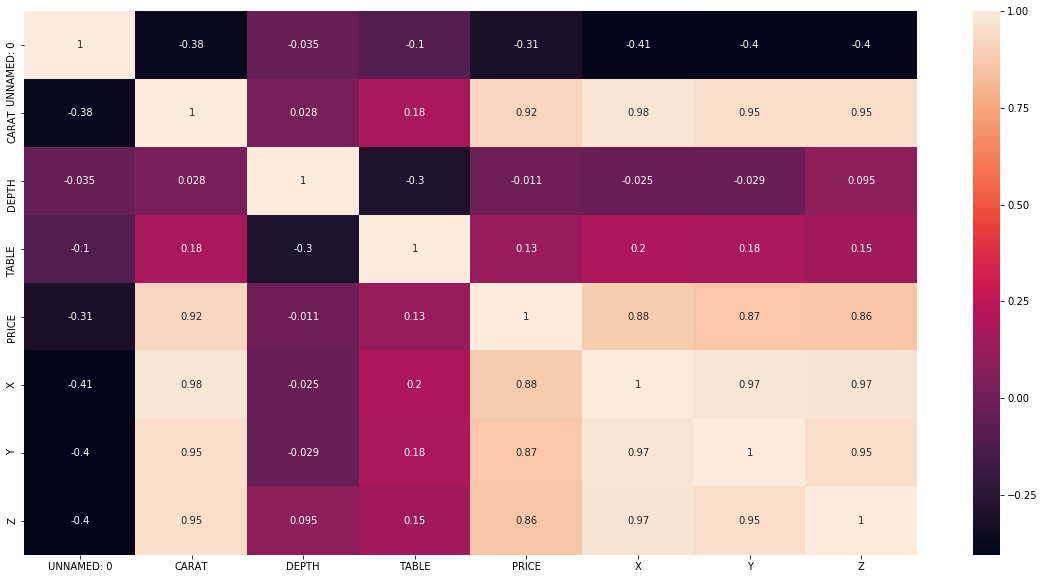

In [5]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True)

Ahora se mostrará la tabla donde se pueden observar el nivel de correlación de los datos, todos aquellos que sea negativos significa que no hay correlación. Por otra parte, todos aquellos que tengan notas arriba de 0.7 significa que su correlacción es fuerte, donde el valor máximo será 1. La diagonal de la tabla será 1, porque es la variable respecto a ella misma.

<div>
    <div class="col-sm-12"><p class="h2">Conclusiones</p> 
    <div class="col-sm-12"><br><br><p class="h3"> Tareas de Preprocesamiento Utilizados</p>
        <table class="table table-condensed list-warnings">
            <tbody>
               <tr>
                    <td><a><code>Analisis Exploratorio de Datos (EDA) </code></a> es un proceso de exploracion y analisis que permite entender el conjunto de datos en estudio.</td>
                    <td>
                        <span class="label label-info">EDA</span>
                    </td>
                </tr>
                <tr>
                    <td><a><code>Normalizacion</code></a> permite estandarizar diferentes escalas en los datos a valores de 0 y 1. </td>
                    <td>
                        <span class="label label-warning">Valores Faltantes</span>
                    </td>
                </tr>
                <tr>
                    <td><a><code>Identificacion de Outliers</code></a> permiten identificar valores anormales en el conjunto de datos.</td>
                    <td>
                        <span class="label label-default">Outliers</span>
                    </td>
                </tr>
                <tr>
                    <td><a><code>Datos No Balanciados</code></a> permite identificar si existe un balance en las distributcion de la informacion, y si la representacion de datos es equitativa. </td>
                    <td>
                        <span class="label label-success">Balance</span>
                    </td>
                </tr>
                <tr>
                    <td> Las <code>Transformaciones</code> permite verificar si es necesario hacer mejoras en el conjunto de datos para mejorar el analisis final. </td>
                    <td>
                        <span class="label label-primary">Transformacion</span>
                    </td>
                </tr>
               </tbody>
        </table>
    <div class="col-sm-12"><br><br><p class="h3"> Analisis de la Informacion</p>
        <table class="table table-condensed list-warnings">
            <tbody>
                <tr>
                    <td>El metodo de <code>Estandarizacion</code> no sera aplicadO para este conjunto de datos  </td>
                    <td>
                        <span class="label label-success">Estandarizacion</span>
                    </td>
                </tr>
                <tr>
                    <td><a>No se presentan <code>Zeros</code></a> en el conjunto de datos. </td>
                    <td>
                        <span class="label label-danger">Zeros</span>
                    </td>
                </tr>
                <tr>
                    <td><a><code>host_name </code></a> tiene alta cardinalidad con 11,428 (23.36%) de datos unicos </td>
                    <td>
                        <span class="label label-info">Unicos</span>
                    </td>
                </tr>
                <tr>
                    <td><a><code>table </code></a> tiene un alto numero de datos unicos. 127 (0.29%)</td>
                    <td>
                        <span class="label label-info">Unicos</span>
                    </td>
                </tr>
                <tr>
                    <td><a><code>depth</code></a> tiene un alto numero de datos unicos. 184 (0.39%) </td>
                    <td>
                        <span class="label label-info">Unicos</span>
                    </td>
                </tr>
                <tr>
                    <td><a><code>caret</code></a> tiene un alto numero de datos unicos. 273 (0.51%)  </td>
                    <td>
                        <span class="label label-info">Unicos</span>
                    </td>
                </tr>
                <tr>
                    <td><a><code>unnamed</code></a> tiene outliers, sin embargo es una caracteristica no utilizable al ser solo un identificador numerico </td>
                    <td>
                        <span class="label label-default">Outliers</span>
                    </td>
                </tr>
                <tr>
                    <td><a><code>price</code></a> tiene outliers, sin embargo al ser el label no sera modificado por el momento. </td>
                    <td>
                        <span class="label label-default">Outliers</span>
                    </td>
                </tr>
               </tbody>
        </table>
        <div class="col-sm-12"><br><br><p class="h3"> Acciones a Tomar</p>
        <table class="table table-condensed list-warnings">
            <tbody>
                <tr>
                    <td>Transformar los Zeros en el Conjunto de Datos </td>
                    <td>
                        <span class="label label-primary">Transformacion</span>
                    </td>
                </tr>
                <tr>
                    <td>Normalizar las variables CARET,X,Y,Z y PRICE </td>
                    <td>
                        <span class="label label-primary">Transformacion</span>
                    </td>
                </tr>
                <tr>
                    <td>Aplicar One Hot Encode a las Variables Categoricas </td>
                    <td>
                        <span class="label label-primary">Transformacion</span>
                    </td>
                </tr>
                <tr>
                    <td>Eliminar la columna UNNAMED, puesto que no agrega valor alguno. </td>
                    <td>
                        <span class="label label-primary">Transformacion</span>
                    </td>
                </tr>
                <tr>
                    <td>Eliminar la columna DEPTH, puesto que no agrega valor alguno. </td>
                    <td>
                        <span class="label label-primary">Transformacion</span>
                    </td>
                </tr>
                <tr>
                    <td>Eliminar la columna TABLE, puesto que no agrega valor alguno. </td>
                    <td>
                        <span class="label label-primary">Transformacion</span>
                    </td>
                </tr>
                <tr>
                    <td>Eliminar la columna CUT, puesto que no agrega valor alguno. </td>
                    <td>
                        <span class="label label-primary">Transformacion</span>
                    </td>
                </tr>
                <tr>
                    <td>Eliminar la columna COLOR, puesto que no agrega valor alguno. </td>
                    <td>
                        <span class="label label-primary">Transformacion</span>
                    </td>
                </tr>
                <tr>
                    <td>Eliminar la columna CLARITY, puesto que no agrega valor alguno. </td>
                    <td>
                        <span class="label label-primary">Transformacion</span>
                    </td>
                </tr>
               </tbody>
        </table>
    </div>
</div>

<div>
    <div class="col-sm-12"><p class="h2">Ejecucion de las Tareas de Preprocesamiento</p> 
    </div>
</div>

Transformar los Zeros en el Conjunto de Datos 

In [0]:
df = df.fillna(0)

Normalizar los datos para que esten en el intervalo (0,1)

In [0]:
processed_data = df
processed_data["PRICE"] = processed_data["PRICE"]/df["PRICE"].max()
processed_data["X"] = processed_data["X"]/df["X"].max()
processed_data["Y"] = processed_data["Y"]/df["Y"].max()
processed_data["Z"] = processed_data["Z"]/df["Z"].max()

In [8]:
print("Muestra de los Datos")
processed_data.head(10)


Muestra de los Datos


,UNNAMED: 0,CARAT,CUT,COLOR,CLARITY,DEPTH,TABLE,PRICE,X,Y,Z
0,1,0.23,IDEAL,E,SI2,61.5,55.0,0.017319,0.367784,0.067572,0.076415
1,2,0.21,PREMIUM,E,SI1,59.8,61.0,0.017319,0.362197,0.065195,0.072642
2,3,0.23,GOOD,E,VS1,56.9,65.0,0.017372,0.377095,0.069100,0.072642
3,4,0.29,PREMIUM,I,VS2,62.4,58.0,0.017744,0.391061,0.071817,0.082704
4,5,0.31,GOOD,J,SI2,63.3,58.0,0.017797,0.404097,0.073854,0.086478
5,6,0.24,VERY GOOD,J,VVS2,62.8,57.0,0.017851,0.366853,0.067233,0.077987
6,7,0.24,VERY GOOD,I,VVS1,62.3,57.0,0.017851,0.367784,0.067572,0.077673
7,8,0.26,VERY GOOD,H,SI1,61.9,55.0,0.017904,0.378957,0.069779,0.079560
8,9,0.22,FAIR,E,VS2,65.1,61.0,0.017904,0.360335,0.064177,0.078302
9,10,0.23,VERY GOOD,H,VS1,59.4,61.0,0.017957,0.372439,0.068761,0.075157


In [9]:
print("Dimension de los Datos")
processed_data.shape

Dimension de los Datos


(53940, 11)

In [10]:
print("Promedio de los Datos")
processed_data.mean()

Promedio de los Datos


UNNAMED: 0    26970.500000
CARAT             0.797940
DEPTH            61.749405
TABLE            57.457184
PRICE             0.208936
X                 0.533627
Y                 0.097360
Z                 0.111281
dtype: float64

In [11]:
print("Max de los Datos")
processed_data.max()

Max de los Datos


UNNAMED: 0        53940
CARAT              5.01
CUT           VERY GOOD
COLOR                 J
CLARITY            VVS2
DEPTH                79
TABLE                95
PRICE                 1
X                     1
Y                     1
Z                     1
dtype: object

In [12]:
print("Min de los Datos")
processed_data.min()

Min de los Datos


UNNAMED: 0            1
CARAT               0.2
CUT                FAIR
COLOR                 D
CLARITY              I1
DEPTH                43
TABLE                43
PRICE         0.0173192
X                     0
Y                     0
Z                     0
dtype: object

Eliminar las columnas, puesto que no agrega valor alguno. 

In [13]:
dataAnalisisPerson = df
del dataAnalisisPerson['UNNAMED: 0'] #eliminar la columna de autonumeración
del dataAnalisisPerson['DEPTH'] #eliminar la columna de depth
del dataAnalisisPerson['TABLE'] #eliminar la columna de table
del dataAnalisisPerson['CUT'] #eliminar la columna de corte
del dataAnalisisPerson['COLOR'] #eliminar la columna de color
del dataAnalisisPerson['CLARITY'] #eliminar la columna de claridad
dataAnalisisPerson.head()


,CARAT,PRICE,X,Y,Z
0,0.23,0.017319,0.367784,0.067572,0.076415
1,0.21,0.017319,0.362197,0.065195,0.072642
2,0.23,0.017372,0.377095,0.069100,0.072642
3,0.29,0.017744,0.391061,0.071817,0.082704
4,0.31,0.017797,0.404097,0.073854,0.086478


Verificar la Correlacion Nuevamente.

In [14]:
plt.figure(figsize=(20, 10))
sns.heatmap(dataAnalisisPerson.corr(), annot=True)

De este análisis podemos concluir que las variables con mayor corelacción al precio son: carat, x, y, z. 
En el gráfico podemos determinarlo por los cuadros en amarillo.

## Visualización por Combinación

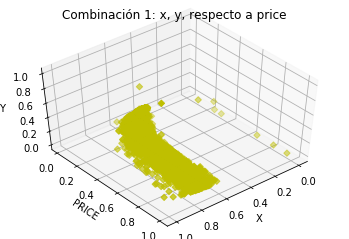

In [15]:
#GRAFICAR LA PRIMERA COMBINACION
fig = plt.figure()
ax = fig.add_subplot (111, projection='3d')


ax.scatter(df['X'], df['PRICE'], df['Y'], c='y', marker='D')

ax.set_xlabel('X')
ax.set_ylabel('PRICE')
ax.set_zlabel('Y')

fig.subplots_adjust(bottom=0.1) 
ax.view_init(50,50)

plt.title("Combinación 1: x, y, respecto a price")
plt.show()


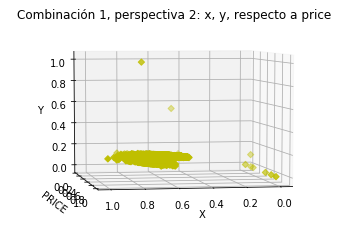

In [16]:
 #GRAFICAR LA PRIMERA COMBINACION
fig = plt.figure()
ax = fig.add_subplot (111, projection='3d')


ax.scatter(df['X'], df['PRICE'], df['Y'], c='y', marker='D')

ax.set_xlabel('X')
ax.set_ylabel('PRICE')
ax.set_zlabel('Y')

fig.subplots_adjust(bottom=0.1) 
ax.view_init(5,80)

plt.title("Combinación 1, perspectiva 2: x, y, respecto a price")
plt.show()

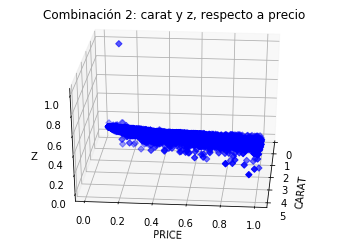

In [17]:
#GRAFICAR LA SEGUNDA COMBINACION
fig = plt.figure()
ax = fig.add_subplot (111, projection='3d')


ax.scatter(df['CARAT'], df['PRICE'], df['Z'], c='b', marker='D')

ax.set_xlabel('CARAT')
ax.set_ylabel('PRICE')
ax.set_zlabel('Z')

fig.subplots_adjust(bottom=0.1) 
ax.view_init(30,5)

plt.title("Combinación 2: carat y z, respecto a precio")
plt.show()


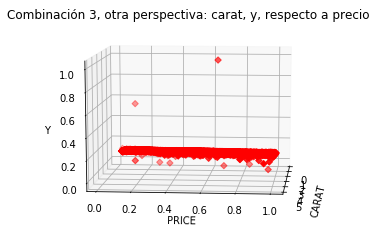

In [18]:
#GRAFICAR LA TERCERA COMBINACION
fig = plt.figure()
ax = fig.add_subplot (111, projection='3d')


ax.scatter(df['CARAT'], df['PRICE'], df['Y'], c='r', marker='D')

ax.set_xlabel('CARAT')
ax.set_ylabel('PRICE')
ax.set_zlabel('Y')

fig.subplots_adjust(bottom=0.1) 
ax.view_init(10,5)

plt.title("Combinación 3, otra perspectiva: carat, y, respecto a precio")
plt.show()

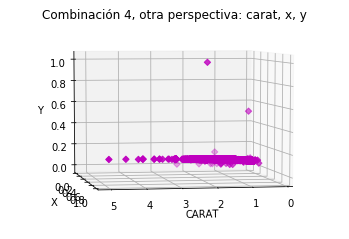

In [19]:

 #GRAFICAR LA CUARTA COMBINACION
fig = plt.figure()
ax = fig.add_subplot (111, projection='3d')


ax.scatter(df['CARAT'], df['X'], df['Y'], c='m', marker='D')

ax.set_xlabel('CARAT')
ax.set_ylabel('X')
ax.set_zlabel('Y')

fig.subplots_adjust(bottom=0.1) 
ax.view_init(5,80)

plt.title("Combinación 4, otra perspectiva: carat, x, y")
plt.show()

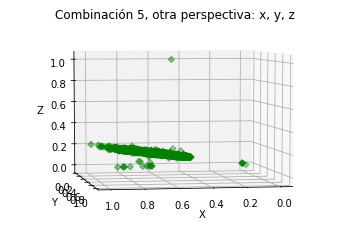

In [20]:

 #GRAFICAR LA QUINTA COMBINACION
fig = plt.figure()
ax = fig.add_subplot (111, projection='3d')


ax.scatter(df['X'], df['Y'], df['Z'], c='g', marker='D')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

fig.subplots_adjust(bottom=0.1) 
ax.view_init(5,80)

plt.title("Combinación 5, otra perspectiva: x, y, z")
plt.show()

## Outliers
En el analisis de datos hemos visto que le precio presenta outliers. Vamos a graficar el precio en un histograma simple.

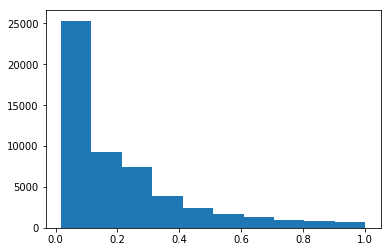

In [21]:
plt.hist(processed_data["PRICE"])
plt.show()

<div>
    <div class="col-sm-12"><p class="h2">Extracción de Características</p> 
    </div>
</div>

In [22]:
from sklearn.model_selection import train_test_split

#Tomar muestras de todo el conjunto de datos

features = processed_data[["X","Y", "Z", "CARAT"]]
features = features.astype('float32')
labels = processed_data[["PRICE"]]
labels = labels.astype('float32')
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, random_state = 13)

# Veamos los datos de caracteristicas y etiquetas
print("Dimensiones de features: #", features.shape)
print("Dimensiones de labels: #", labels.shape)

# Veamos los datos de entrenamiento
print('x_train shape:', X_train.shape)
print('y_train shape:', Y_train.shape)

# Ahora veamos los datos que se han guardado para la predicción  
print('x_Predict shape:', X_test.shape)
print('y_Predict shape:', Y_test.shape) 

Dimensiones de features: # (53940, 4)
Dimensiones de labels: # (53940, 1)
x_train shape: (40455, 4)
y_train shape: (40455, 1)
x_Predict shape: (13485, 4)
y_Predict shape: (13485, 1)


<div>
    <div class="col-sm-12"><p class="h2">Clasificación</p> 
    </div>
</div>

In [0]:
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

<div>
    <div class="col-sm-12"><p class="h2">Evaluación de Regresión Lineal</p> 
    </div>
</div>

In [24]:
# Ver curva de apendizaje del modelo 

train_sizes, train_scores, validation_scores = learning_curve(estimator = LinearRegression(),
X = X_train,y = Y_train, train_sizes = [1, 100, 1000, 5000, 10000, 32364], cv = 5,
scoring = 'neg_mean_squared_error')

print('Puntaje de Entrenamiento:\n\n', train_scores)
print('\n', '-' * 70) 
print('\nPuntaje de Evaluación:\n\n', validation_scores)

Puntaje de Entrenamiento:

 [[-0.         -0.         -0.         -0.         -0.        ]
 [-0.0022583  -0.00837184 -0.00837184 -0.00837184 -0.00837184]
 [-0.00593121 -0.0067933  -0.0067933  -0.0067933  -0.0067933 ]
 [-0.00599369 -0.00646858 -0.00646858 -0.00646858 -0.00646858]
 [-0.00607058 -0.00637628 -0.00639293 -0.00639293 -0.00639293]
 [-0.00647425 -0.00658362 -0.00659279 -0.00629362 -0.00642262]]

 ----------------------------------------------------------------------

Puntaje de Evaluación:

 [[-0.07678386 -0.0646737  -0.06417671 -0.06913545 -0.06708434]
 [-0.00778895 -0.00806211 -0.00741571 -0.01873572 -0.01145056]
 [-0.0064787  -0.00645102 -0.00628339 -0.01003285 -0.02277669]
 [-0.00651159 -0.00615557 -0.00607628 -0.00800997 -0.01673994]
 [-0.00649052 -0.00609779 -0.00604023 -0.00740979 -0.0140427 ]
 [-0.00658761 -0.00614165 -0.00610383 -0.00746157 -0.01469723]]


In [25]:
#Saca el promedio de los valores generados en el paso anterior
train_scores_mean = -train_scores.mean(axis = 1)

validation_scores_mean = -validation_scores.mean(axis = 1)

print('Porcentaje de Puntaje de Entrenamiento\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20)
print('\nPorcentaje de Puntaje de Validación\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Porcentaje de Puntaje de Entrenamiento

 1       -0.000000
100      0.007149
1000     0.006621
5000     0.006374
10000    0.006325
32364    0.006473
dtype: float64

 --------------------

Porcentaje de Puntaje de Validación

 1        0.068371
100      0.010691
1000     0.010405
5000     0.008699
10000    0.008016
32364    0.008198
dtype: float64


(0, 0.1)

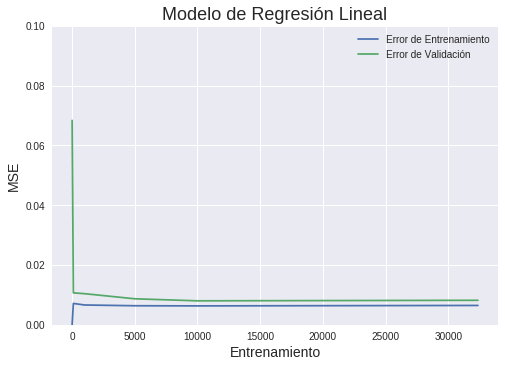

In [26]:
#Graficar el puntaje de entrenamiento y el error de validación

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Error de Entrenamiento')
plt.plot(train_sizes, validation_scores_mean, label = 'Error de Validación')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Entrenamiento', fontsize = 14)
plt.title('Modelo de Regresión Lineal', fontsize = 18, y = 1)
plt.legend()
plt.ylim(0,0.1)

<div>
    <div class="col-sm-12"><p class="h2">Ejecutar Modelo de Regresión Lineal</p> 
    </div>
</div>

In [0]:
#Complilar el modelo de apendizaje

LinearRegressionModel = LinearRegression()
LinearRegressionModel = LinearRegressionModel.fit(X_train, Y_train)
y_linear = LinearRegressionModel.predict(X_train) 

<div>
    <div class="col-sm-12"><p class="h2">Validación de Regresión Lineal</p> 
    </div>
</div>

In [28]:
#Define el puntaje de la predicción mediante el uso del coeficiente de determinación
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

from sklearn.metrics import r2_score
print ("El score usando r2 del modelo de regresión lineal es: ", r2_score(Y_train, y_linear))  

El score usando r2 del modelo de regresión lineal es:  0.8553320612235333


## Evaluación del modelo de Regresión: Arbol de Decisión

In [29]:
# Ver curva de apendizaje del modelo 

train_sizes, train_scores, validation_scores = learning_curve(estimator = DecisionTreeRegressor(max_depth=3),
X = X_train,y = Y_train, train_sizes = [1, 100, 1000, 5000, 10000, 32364], cv = 5,
scoring = 'neg_mean_squared_error')

print('Puntaje de Entrenamiento:\n\n', train_scores)
print('\n', '-' * 70) 
print('\nPuntaje de Validación:\n\n', validation_scores)

Puntaje de Entrenamiento:

 [[-0.         -0.         -0.         -0.         -0.        ]
 [-0.00152954 -0.00504727 -0.00504727 -0.00504727 -0.00504727]
 [-0.0049506  -0.00524708 -0.00524708 -0.00524708 -0.00524708]
 [-0.00555496 -0.00572264 -0.00572264 -0.00572264 -0.00572264]
 [-0.00571042 -0.00578717 -0.00576732 -0.00576732 -0.00576732]
 [-0.0058207  -0.00587071 -0.00586465 -0.00571795 -0.00582663]]

 ----------------------------------------------------------------------

Puntaje de Validación:

 [[-0.07678385 -0.06467371 -0.06417671 -0.06913545 -0.06708435]
 [-0.00848746 -0.00801705 -0.0076939  -0.00813907 -0.00806106]
 [-0.00641537 -0.00592287 -0.00580571 -0.00631796 -0.00598308]
 [-0.00596576 -0.0058863  -0.0058007  -0.00639803 -0.00606255]
 [-0.00580075 -0.00579985 -0.00573363 -0.00639235 -0.00592121]
 [-0.00583187 -0.00568762 -0.00568208 -0.00625381 -0.00582611]]


In [30]:
#Calcula el promedio de los valores generados en el paso anterior

train_scores_mean = -train_scores.mean(axis = 1)

validation_scores_mean = -validation_scores.mean(axis = 1)

print('Porcentaje de Puntaje de Entrenamiento\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20)
print('\nPorcentaje de Puntaje de Validación\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Porcentaje de Puntaje de Entrenamiento

 1       -0.000000
100      0.004344
1000     0.005188
5000     0.005689
10000    0.005760
32364    0.005820
dtype: float64

 --------------------

Porcentaje de Puntaje de Validación

 1        0.068371
100      0.008080
1000     0.006089
5000     0.006023
10000    0.005930
32364    0.005856
dtype: float64


(0, 0.1)

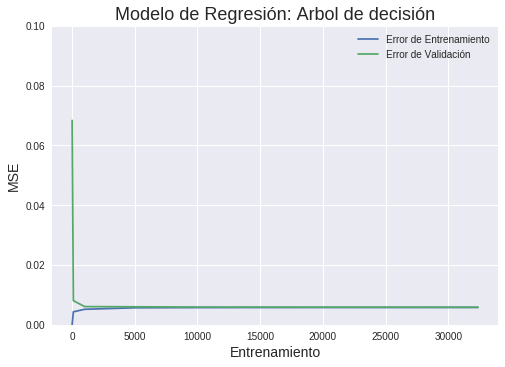

In [31]:
#Grafica el puntaje de entrenamiento y el error de validacion

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Error de Entrenamiento')
plt.plot(train_sizes, validation_scores_mean, label = 'Error de Validación')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Entrenamiento', fontsize = 14)
plt.title('Modelo de Regresión: Arbol de decisión', fontsize = 18, y = 1)
plt.legend()
plt.ylim(0,0.1)

## Ejecutar Modelo de Regresión: Arbol de decisión

In [0]:
#Ejecuta el modelo

DecisionTreeModel = DecisionTreeRegressor(max_depth=3)
DecisionTreeModel.fit(X_train,Y_train)
y_tree = DecisionTreeModel.predict(X_test)

<div>
    <div class="col-sm-12"><p class="h2">Validación del árbol de decisión</p> 
    </div>
</div>

In [33]:
#Define el Score de la Prediccion mediante el uso del coeficiente de determinacion
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

r2_score(Y_test, y_tree) 

0.8723564096070711

# Red Neuronal

In [1]:
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import pytz
import scipy.stats as stats

from tabulate import tabulate
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import KFold


Using TensorFlow backend.


Se ha seleccionado el uso de regression con keras, para desarrollar la red neuronal. 

In [0]:
#Vamos a iniciar la carga de datos desde 0 para la red, dado que los datos han sido modificados y variados anteriormente, en los otros modelos. 

#Diamonds_Corto es un conjunto de datos reducido para pruebas rápidas, esta cortado sin buscar equilibrio, de modo que las corridas con estos datos 
#son unicamente para encontrar errores de código. 

#data = pd.read_csv('https://raw.githubusercontent.com/NataliaGRC/DataScience/master/diamonds_Corto.csv')

#Set de datos completo
datos_Diamantes = pd.read_csv('https://raw.githubusercontent.com/NataliaGRC/DataScience/master/diamonds.csv')


## Visualización de datos

In [3]:
#Observación rápida de los datos
print(datos_Diamantes)

       Unnamed: 0  carat        cut color  ... price     x     y     z
0               1   0.23      Ideal     E  ...   326  3.95  3.98  2.43
1               2   0.21    Premium     E  ...   326  3.89  3.84  2.31
2               3   0.23       Good     E  ...   327  4.05  4.07  2.31
3               4   0.29    Premium     I  ...   334  4.20  4.23  2.63
4               5   0.31       Good     J  ...   335  4.34  4.35  2.75
5               6   0.24  Very Good     J  ...   336  3.94  3.96  2.48
6               7   0.24  Very Good     I  ...   336  3.95  3.98  2.47
7               8   0.26  Very Good     H  ...   337  4.07  4.11  2.53
8               9   0.22       Fair     E  ...   337  3.87  3.78  2.49
9              10   0.23  Very Good     H  ...   338  4.00  4.05  2.39
10             11   0.30       Good     J  ...   339  4.25  4.28  2.73
11             12   0.23      Ideal     J  ...   340  3.93  3.90  2.46
12             13   0.22    Premium     F  ...   342  3.88  3.84  2.33
13    

In [4]:
#encabezado de los datos
datos_Diamantes.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Orden de los datos (mejor dicho, desordenar los datos)**

Como se puede observar en el despliegue de datos rápido, los datos parecen estar agrupados por precio, por lo tanto, vamos a hacer un mix aleatorio de los datos, para que sea lo más aleatorio posible.

In [0]:
from sklearn.utils import shuffle
datos_Diamantes = shuffle(datos_Diamantes)

Veamos rápidamente como quedo.

In [6]:
print(datos_Diamantes)

       Unnamed: 0  carat        cut color  ...  price     x     y     z
48260       48261   0.54  Very Good     E  ...   1955  5.10  5.17  3.25
12960       12961   1.21      Ideal     J  ...   5390  6.79  6.84  4.27
16396       16397   1.23       Good     G  ...   6545  6.78  6.81  4.29
22713       22714   1.23  Very Good     E  ...  10730  6.88  6.93  4.25
39735       39736   0.38      Ideal     D  ...   1092  4.62  4.67  2.90
4938         4939   0.98  Very Good     H  ...   3731  6.33  6.39  3.95
11687       11688   1.03      Ideal     H  ...   5063  6.53  6.47  4.03
8669         8670   1.04    Premium     G  ...   4455  6.49  6.42  4.04
43989       43990   0.21    Premium     E  ...    394  3.84  3.82  2.37
27053       27054   0.35      Ideal     G  ...    646  4.54  4.58  2.80
8433         8434   1.08  Very Good     F  ...   4407  6.55  6.61  4.12
34150       34151   0.33    Premium     H  ...    854  4.45  4.42  2.73
31104       31105   0.36      Ideal     E  ...    753  4.58  4.6

### Preprocesado de datos

Como ya sabemos de los análisis que se han hecho para los modelos anteriores, las columnas: UNNAMED: 0, DEPTH, TABLE, CUT, COLOR, CLARITY no serán utilizadas, dado que no hay correlacción con el precio.

In [0]:
#pasamos los datos al objeto processed_data para saber que ahí tendremos los datos a los cuales les hacemos preprocesamiento de datos
processed_dataRN = datos_Diamantes

Eliminar las columnas que no se utilizarán

In [0]:
#eliminar las columnas que no serán utilizadas
del processed_dataRN['Unnamed: 0'] #eliminar la columna de autonumeración
del processed_dataRN['depth'] #eliminar la columna de depth
del processed_dataRN['table'] #eliminar la columna de table
del processed_dataRN['cut'] #eliminar la columna de corte
del processed_dataRN['color'] #eliminar la columna de color
del processed_dataRN['clarity'] #eliminar la columna de claridad

Remover los NaNs (para este caso en particular sabemos que no existen, pero igual ejecutamos el paso)

In [0]:
# Remover los NaNs 
processed_dataRN = processed_dataRN.fillna(0)


**Eliminar los outliers**

Del análisis realizado anteriormente sabemos que el precio tiene outliers, veamos nuevamente la gráfica.
Esto es importante, porque se hicieron varias pruebas sin eliminarlos, entonces, siempre daba resultados del score iguales aunque se modificaran parámetros. No debemos olvidar que las redes neuronales son sensibles a la escala y a los outliers.

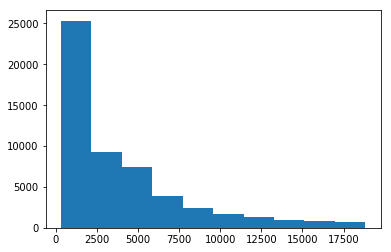

In [10]:
plt.hist(processed_dataRN["price"])
plt.show()

Podemos observar que hay un pico de precio aproximadamente de los 2,500 dólares en adelante.

In [11]:
#Observamos el encabezado de los datos
processed_dataRN.head()

,carat,price,x,y,z
48260,0.54,1955,5.10,5.17,3.25
12960,1.21,5390,6.79,6.84,4.27
16396,1.23,6545,6.78,6.81,4.29
22713,1.23,10730,6.88,6.93,4.25
39735,0.38,1092,4.62,4.67,2.90


In [12]:
#Observemos la parte final de los datos
processed_dataRN.tail()

,carat,price,x,y,z
22920,1.55,10960,7.38,7.40,4.61
35893,0.32,918,4.42,4.45,2.74
37315,0.38,979,4.62,4.65,2.87
3186,0.71,3342,5.77,5.79,3.53
22640,1.51,10688,7.30,7.26,4.53


In [13]:
#Ahora veremos las dimensiones de los datos
processed_dataRN.shape

(53940, 5)

In [14]:
#Media de los datos
processed_dataRN.mean()

carat       0.797940
price    3932.799722
x           5.731157
y           5.734526
z           3.538734
dtype: float64

In [15]:
#Valor máximo de cada uno de los datos
processed_dataRN.max()

carat        5.01
price    18823.00
x           10.74
y           58.90
z           31.80
dtype: float64

Al ver el valor medio y observar el valor máximo, es evidente que si debemos eliminar el outlier.
**Aplicamos el filtro sobre el precio.**

In [0]:
processed_dataRN = processed_dataRN.query('price<2500')

Ahora veamos en un histograma la distribución de la variable precio, nuevamente.

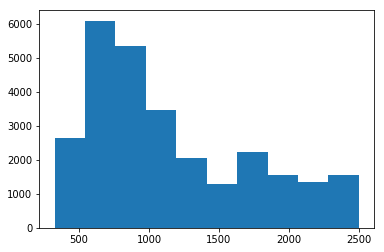

In [17]:
plt.hist(processed_dataRN["price"])
plt.show()

### MUCHO MEJOR !!!   :-)

**El diagrama nos muestra una mejor distribución.**

Ahora, veamos las dimensiones del set de datos sin los outliers. 

In [18]:
processed_dataRN.shape

(27540, 5)

In [0]:
# PASO IMPORTANTE
#Normalizar los datos para que esten en el intervalo (0,1)
 
processed_dataRN["price"] = processed_dataRN["price"]/processed_dataRN["price"].max()
processed_dataRN["x"] = processed_dataRN["x"]/processed_dataRN["x"].max()
processed_dataRN["y"] = processed_dataRN["y"]/processed_dataRN["y"].max()
processed_dataRN["z"] = processed_dataRN["z"]/processed_dataRN["z"].max()

In [20]:
#ahora volvemos a observar la media
processed_dataRN.mean()

carat    0.434621
price    0.461147
x        0.701846
y        0.151653
z        0.093525
dtype: float64

In [21]:
#Observamos la nueva media de los datos
processed_dataRN.max()

carat    1.21
price    1.00
x        1.00
y        1.00
z        1.00
dtype: float64

In [22]:
#Ahora observaremos el encabezado de los datos normalizados
processed_dataRN.head()

,carat,price,x,y,z
48260,0.54,0.782313,0.743440,0.162579,0.102201
39735,0.38,0.436975,0.673469,0.146855,0.091195
43989,0.21,0.157663,0.559767,0.120126,0.074528
27053,0.35,0.258503,0.661808,0.144025,0.088050
34150,0.33,0.341737,0.648688,0.138994,0.085849


### Creación de una Muestra de los Datos.

In [23]:
# Separar los datos en X y Y 
# se tomaran las caracteristicas que fueron mjs relevantes con la correlación con el precio. 

XRN =  np.array(processed_dataRN[["x","y", "z", "carat"]]) 
XRN = XRN.astype('float32')
yRN = np.array(processed_dataRN[["price"]]) 
yRN = yRN.astype('float32')

print("Dimensiones de X: #", XRN.shape)


print("Dimensiones de Y: #", yRN.shape)

Dimensiones de X: # (27540, 4)
Dimensiones de Y: # (27540, 1)


In [24]:
# Separamos los datos en entrenamiento y testing, pero vamos a reservar una pequeña parte para que una vez que el modelo este entrenado probemos 
# la predicción de datos, como si estuvieramos en una compra de diamentes, esto quedara en las variables Predict  
"""
#Cuando trabajamos con el set corto
(X_train, X_test,  X_Predict) = X[250:], X[:200], X[:50]
(y_train, y_test,  y_Predict ) = y[250:], y[:200], y[:50]
"""

#Cuando trabajamos con el set grande
#Aqui voy a reservar unos datos para el modelo cuando ya este entrenado  y testeado
#Si el total de datos es: 27540, pero vamos a reservar 50 para predicción
(X_Disminuido,  X_PredictRN) = XRN[50:],  XRN[:50]
(y_Disminuido,y_PredictRN ) = yRN[50:],  yRN[:50]

print("El data set disminuido:")
print("Y: ", y_Disminuido.shape)
print("X: ", X_Disminuido.shape)

#ahora repartimos los datos para training y test
#Si el total de datos es: 27490, el 80% es: 21992 y el 20% es: 5498
(X_trainRN, X_testRN) = X_Disminuido[5498:], X_Disminuido[:5498] 
(y_trainRN, y_testRN) = y_Disminuido[5498:], y_Disminuido[:5498]


# Veamos los datos de entrenamiento
print('x_train shape:', X_trainRN.shape)
print('y_train shape:', y_trainRN.shape)


# Veamos los datos de entrenamiento
print('x_test shape:', X_testRN.shape)
print('y_test shape:', y_testRN.shape)

# Ahora veamos los datos que se han guardado para la predicción  
print('x_Predict shape:', X_PredictRN.shape)
print('y_Predict shape:', y_PredictRN.shape) 



El data set disminuido:
Y:  (27490, 1)
X:  (27490, 4)
x_train shape: (21992, 4)
y_train shape: (21992, 1)
x_test shape: (5498, 4)
y_test shape: (5498, 1)
x_Predict shape: (50, 4)
y_Predict shape: (50, 1)


In [0]:
# se define el modelo base
def modelo():
  # creamos el modelo
  model = Sequential()
  model.add(Dense(64, input_dim=4, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(8,  activation='relu'))
  model.add(Dense(1,  activation='softmax'))
  # se Compila el modelo
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.summary()
   
  return model

In [0]:
# semilla de aletoriedad para el calculo de kfold
seed = 7
np.random.seed(seed)

# evalua el modelo definido
estimator = KerasRegressor(build_fn=modelo, epochs=10, batch_size=500, verbose=0)

In [27]:
#no cambio shuffle a true, proque ya hice la mezcla de datos por programación
kfold = KFold(n_splits=20, random_state=seed) 

print(kfold)

KFold(n_splits=20, random_state=7, shuffle=False)


In [28]:
formatoFH = '%Y-%m-%d %H:%M:%S %z'

fechaHora = datetime.datetime.now(pytz.timezone("America/Costa_Rica"))
fechaHoraStr = fechaHora.strftime(formatoFH)
 
print ("Hora de inicio:", fechaHoraStr )


Hora de inicio: 2019-09-09 21:49:48 -0600


En el siguiente paso, no vamos a usar todo el X, Y para el cross validator score,dado que reservamos unos datos para hacer prediciones del modelo.

In [29]:
score = cross_val_score(estimator, X_trainRN, y_trainRN, cv=kfold)






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 2,673
Trainable params: 2,673
Non-trainable params: 0
_________________________________________________________________


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                320       
________________________

**Una vez ejecutada la evaluación, mostraremos el cálculo del error.**

In [30]:
print("Baseline: %.2f (%.2f) MSE" % (score.mean(), score.std()))

Baseline: -0.34 (0.01) MSE


In [31]:
formatoFH = '%Y-%m-%d %H:%M:%S %z'

fechaHora = datetime.datetime.now(pytz.timezone("America/Costa_Rica"))
fechaHoraStr = fechaHora.strftime(formatoFH)
 
print ("Hora de inicio:", fechaHoraStr )


Hora de inicio: 2019-09-09 21:50:38 -0600


### Curva de aprendizaje

Para poder observar que ha sucedido con el aprendizaje de nuestro modelo de forma gráfica, encontramos una recomendación del uso de la librería learning_curve. 
Vamos a conservar los parámetros del train_sizes con los valores default.

In [32]:
from sklearn.model_selection import learning_curve

train_sizesRN, train_scoresRN, test_scoresRN = learning_curve(estimator,
                        X_trainRN, y_trainRN, 
                        train_sizes=np.linspace(0.1, 1.0, 5), cv=kfold)
                        

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_82 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_83 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 9         
Total params: 2,673
Trainable params: 2,673
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 64)                320       
____________________________

Obtenemos los datos necesarios de para poder graficar la curva de aprendizaje, de la corrida del modelo.

In [0]:
train_mean = np.mean(train_scoresRN, axis=1)
train_std = np.std(train_scoresRN, axis=1)
test_mean = np.mean(test_scoresRN, axis=1)
test_std = np.std(test_scoresRN, axis=1)

Ahora procedemos a ejecutar la gráfica de la curva de aprendizaje. 

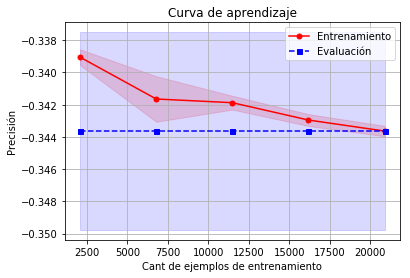

In [34]:
# graficando las curvas
plt.plot(train_sizesRN, train_mean, color='r', marker='o', markersize=5,
          label='Entrenamiento')
plt.fill_between(train_sizesRN, train_mean + train_std, 
                 train_mean - train_std, alpha=0.15, color='r')
plt.plot(train_sizesRN, test_mean, color='b', linestyle='--', 
         marker='s', markersize=5, label='Evaluación')
plt.fill_between(train_sizesRN, test_mean + test_std, 
                 test_mean - test_std, alpha=0.15, color='b')
plt.grid()
plt.title('Curva de aprendizaje')
plt.legend(loc='upper right')
plt.xlabel('Cant de ejemplos de entrenamiento')
plt.ylabel('Precisión')
plt.show()

# Predicción

La predicción es el desenlace del trabajo que uno realiza al crear una red, porque la entrenamos y la probamos para ver su comportamiento, y así quedará lista para ser utilizada en la vida real. 
Para realizar esta labor tuvimos que investigar.
Un detalle sumamente importante es que los datos que vamos a usar aqui fueron reservados al dividir los datos, para que estos nunca sean vistos por el modelo.

In [35]:
#estos son los datos que reservamos para las pruebas de predicción, para simular la vida real.

for i in range(len(X_PredictRN)):
	print("X=%s, ValorReal=%s" % (X_PredictRN[i], y_PredictRN[i]))

X=[0.7434402  0.16257861 0.10220126 0.54      ], ValorReal=[0.7823129]
X=[0.67346936 0.14685534 0.09119496 0.38      ], ValorReal=[0.4369748]
X=[0.55976677 0.12012579 0.0745283  0.21      ], ValorReal=[0.15766306]
X=[0.6618076  0.14402516 0.08805031 0.35      ], ValorReal=[0.2585034]
X=[0.648688   0.13899371 0.08584905 0.33      ], ValorReal=[0.3417367]
X=[0.6676385  0.14654088 0.08930817 0.36      ], ValorReal=[0.30132052]
X=[0.7536443  0.16132076 0.10188679 0.53      ], ValorReal=[0.565026]
X=[0.622449   0.13584906 0.08490566 0.3       ], ValorReal=[0.21048419]
X=[0.66909623 0.14591195 0.08553459 0.35      ], ValorReal=[0.30692276]
X=[0.6457726  0.14025158 0.08679245 0.33      ], ValorReal=[0.312525]
X=[0.73323613 0.15660377 0.09842768 0.49      ], ValorReal=[0.4105642]
X=[0.75072885 0.16069183 0.09968553 0.5       ], ValorReal=[0.8643457]
X=[0.7740525  0.16792452 0.10314465 0.56      ], ValorReal=[0.77991194]
X=[0.69970846 0.14968553 0.09402516 0.42      ], ValorReal=[0.43497398]
X=

Uno de los problemas que teníamos la hora de ejecutar la predicción, es que daba un error que no teníamos el método predict, y encontramos que debemos hacer un .fit antes de poder predecir.

In [36]:
#debemos entrenar el modelo para poder predecir primero
#Se usa el reducido que es al que se le hizo el preprocsado y se le quitaron los outliers.

estimator.fit(X_Disminuido, y_Disminuido, epochs=2000, batch_size=200, verbose=False, shuffle=False)

Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_481 (Dense)            (None, 64)                320       
_________________________________________________________________
dense_482 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_483 (Dense)            (None, 8)                 264       
_________________________________________________________________
dense_484 (Dense)            (None, 1)                 9         
Total params: 2,673
Trainable params: 2,673
Non-trainable params: 0
_________________________________________________________________


Una vez entrenado el modelo, procedemos a predecir.

In [0]:
yPrediccionRN = estimator.predict(X_PredictRN)

Ahora mostremos lo que hizo.

In [38]:
 
for i in range(len(yPrediccionRN)):
	print("X=%s, Predicción=%s, ValorReal=%s" % (X_PredictRN[i], yPrediccionRN[i], y_PredictRN[i]))
  
 

X=[0.7434402  0.16257861 0.10220126 0.54      ], Predicción=1.0, ValorReal=[0.7823129]
X=[0.67346936 0.14685534 0.09119496 0.38      ], Predicción=1.0, ValorReal=[0.4369748]
X=[0.55976677 0.12012579 0.0745283  0.21      ], Predicción=1.0, ValorReal=[0.15766306]
X=[0.6618076  0.14402516 0.08805031 0.35      ], Predicción=1.0, ValorReal=[0.2585034]
X=[0.648688   0.13899371 0.08584905 0.33      ], Predicción=1.0, ValorReal=[0.3417367]
X=[0.6676385  0.14654088 0.08930817 0.36      ], Predicción=1.0, ValorReal=[0.30132052]
X=[0.7536443  0.16132076 0.10188679 0.53      ], Predicción=1.0, ValorReal=[0.565026]
X=[0.622449   0.13584906 0.08490566 0.3       ], Predicción=1.0, ValorReal=[0.21048419]
X=[0.66909623 0.14591195 0.08553459 0.35      ], Predicción=1.0, ValorReal=[0.30692276]
X=[0.6457726  0.14025158 0.08679245 0.33      ], Predicción=1.0, ValorReal=[0.312525]
X=[0.73323613 0.15660377 0.09842768 0.49      ], Predicción=1.0, ValorReal=[0.4105642]
X=[0.75072885 0.16069183 0.09968553 0.5  

# CONCLUSIONES

### Trabajo inicial para seleccionar los datos


1. El análisis de correlación fue escencial para determinar si los conjuntos de datos tenial relacion alguna y así poder determinar si seguiamos o no con el set de datos seleccionado. 
2. Dentro de las recomendaciones del profesor estaba no divagar mucho buscando un set de datos que a uno le "apasionara", sin embargo, inicialmente al buscar datos de Costa Rica no se siguió dicha recommendación y se invirtió gran cantidad de tiempo para transformar datos del formato que expone INEC (.SAV) a CSV, se seleccionó un conjunto de datos de desempleo del I Trimestre, el objetivo de la red sería: Predecir el desempleo. Los mismos se descartaron por recomendación del profesor, dado que había visto casos similares que no llegaron a nada. 
3. Se trabajo el data set de Arb&b (https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data)  pero el mismo no mostró correlacción entre los datos, adicionalmente el profesor nos comentó: un feature de sentimiento, involucra NLP lo cual está más allá de lo solicitado en el proyecto, por lo tanto lo dejamos.
4. El de tarjetas de crétido (https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) tampoco generó correlaciones importantes y no se trabajó más en él. 
5. En el caso del dataset seleccionados se tuvieron algunos aprendizajes importantes como: 


*   Generalmente un diamente es valorado por su claridad, corte, peso(carat), color, pero de estas características la que resultó con una correlacción fuerte fue el peso y las dimensiones.
*   Las variables categóricas se usaron dentro del análisis pero resultaron no tener corelacción con el precio y se eliminaron del dataset.




## Trabajando con la red neuronal

### 1. Normalizar los datos. 

Como parte de la materia vista en el curso, el profesor nos explico que la "kryptonita" de las redes neuronales era la escala, de ahí la importancia para obtener buenos resultados, ejecutar una normalización de los mismos.

### 2. Eliminar los outliers.

Del análisis realizado sabíamos que el precio tenía outliers, esto es importante, porque se hicieron varias pruebas sin eliminarlos, y los resultados eran terribles. Recordando que las redes neuronales son sensibles a la escala y a los picos de datos (outliers). Se quitaron y listo! empezamos a tener mejores resultados.

### 3. Medición del error. 

En un sitio encontramos una recomendación que al ser una predicción, utilizaramos el MSE (Mean Squared Error) y que en cada EPOCH debería de ir reduciendose.

### 4. Funciones de activación.

Seleccionamos "relu" para la funcion de activación de las capas intermedias, porque trabajaremos con datos desde 0 hasta 1. 
Seleccionamos "softmax" para la función de activación de la capa de salida, porque no es algo binario, y esta fue la recomendación del profesor en clase.


### 5. Investigación. 
Revisando algunos trabajos en la Web, encontramos uno de predicción de precios de casas en Boston, pero no utilizaron una red neuronal, sino un árbol de decisión, viendo los resultados de la red, quizás el tipo de problema sea más apto para un árbol. https://medium.com/datos-y-ciencia/proyecto-machine-learning-predicci%C3%B3n-de-precios-de-viviendas-en-boston-con-regresi%C3%B3n-e8655e6c3655 


## Conclusiones Generales

 

1.   El análisis exploratorio de datos es crucial y de suma importancia, puesto que permite determinar las acciones necesarias para el procesamiento, además permite analisis de forma visual y por tanto facilita el entendimiento de como se comporta el conjunto de datos.
2.   La normalización del conjunto de datos, nos dio la clave para mejorar por mucho el modelo de aprendizaje, inicialmente teníamos malos resultados y luego de aplicar este método se lograron entre 85% y 87% porciento en la ejecición.
3.   En los modelos de regresión, es escencial eliminar los Nans o Zeros, dado que los modelo fallan si están presentes. Si bien para el conjunto de datos de diamantes no fue necesario, si para otros dataset analizados. 



 

 



**Muchas gracias por tomarse el tiempo para leer todas las conclusiones obtenidas en este trabajo.**